<a href="https://colab.research.google.com/github/lebedevAU/N1/blob/main/%D0%9E%D0%B1%D1%83%D1%87%D0%B0%D1%8E%D1%89%D0%B0%D1%8F_%D0%B8_%D1%82%D0%B5%D1%81%D1%82%D0%BE%D0%B2%D0%B0%D1%8F_%D0%B2%D1%8B%D0%B1%D0%BE%D1%80%D0%BA%D0%B8_(%D0%A3%D0%BD%D0%B8%D0%B2%D0%B5%D1%80%D1%81%D0%B8%D1%82%D0%B5%D1%82_%D0%B8%D1%81%D0%BA%D1%83%D1%81%D1%81%D1%82%D0%B2%D0%B5%D0%BD%D0%BD%D0%BE%D0%B3%D0%BE_%D0%B8%D0%BD%D1%82%D0%B5%D0%BB%D0%BB%D0%B5%D0%BA%D1%82%D0%B0).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Теоретический материал:* https://youtu.be/oPcBGVZ6aSU

Чтобы запускать и редактировать код, сохраните копию этого ноутбука себе (File->Save a copy in Drive...). Свою копию вы сможете изменять и запускать.

# Оценка качества обучения нейронной сети в Keras

*Разбор данного раздела:* https://youtu.be/ZNVupJXQisM?t=31

In [ ]:
from tensorflow.keras.models import Sequential # НС прямого распространения
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization # Основные слои
from tensorflow.keras import utils # Утилиты для to_categorical
from tensorflow.keras.preprocessing import image # Для отрисовки изображения
from tensorflow.keras.optimizers import Adam, Adadelta # Алгоритмы оптимизации, для настройки скорости обучения
import numpy as np # Библиотека работы с массивами
import matplotlib.pyplot as plt # Отрисовка изображений
from PIL import Image # Отрисовка изображений
import pandas as pd # Библиотека pandas
from google.colab import files # Импорт файлов
from sklearn.preprocessing import LabelEncoder, StandardScaler # Функции для нормализации данных
from sklearn import preprocessing # Пакет предварительной обработки данных

# Отрисовывать изображения в ноутбуке, а не в консоль или файл
%matplotlib inline


##Загрузка файла

*Разбор данного раздела:* https://youtu.be/ZNVupJXQisM?t=120

In [ ]:
# Загружаем файлы
files.upload()
!ls # Выводим содержимое корневой папки

## Загрузка данных

In [ ]:
# Загружаем данные из файла sonar.csv
df = pd.read_csv("sonar.csv", header=None)   # header=None, когда данные не имеют строки с заголовками
df.head()                                    # Выводим первые 5 строк наших данных

0       1       2       3       4   ...      56      57      58      59  60
0  0.0200  0.0371  0.0428  0.0207  0.0954  ...  0.0180  0.0084  0.0090  0.0032   R
1  0.0453  0.0523  0.0843  0.0689  0.1183  ...  0.0140  0.0049  0.0052  0.0044   R
2  0.0262  0.0582  0.1099  0.1083  0.0974  ...  0.0316  0.0164  0.0095  0.0078   R
3  0.0100  0.0171  0.0623  0.0205  0.0205  ...  0.0050  0.0044  0.0040  0.0117   R
4  0.0762  0.0666  0.0481  0.0394  0.0590  ...  0.0072  0.0048  0.0107  0.0094   R

[5 rows x 61 columns]

In [ ]:
print(df.shape) # Размерность данных

(208, 61)


In [ ]:
dataset = df.values                 # Берем только значения массива(без индексов)
X = dataset[:,0:60].astype(float)   # Присваиваем им тип данных - float(с плавающей точкой) данным с 0 по 60 колонки
Y = dataset[:,60]                   # Присваеваем значению Y данные из столбца с индексом 60
Y[Y=='R']='0'                       # Если значение элемента столбца равно 'R', присваеваем ему значение '0'
Y[Y=='M']='1'                       # Если значение элемента столбца равно 'Y', присваеваем ему значение '1'
Y = Y.astype(int)                   # Меняем тип данных столбца на 'int'(целочисленный тип данных)
print(X.shape)                      # Выводим размерность X
print(Y.shape)                      # Выводим размерность Y
print(Y)                            

(208, 60)
(208,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


## Создание обучающей, проверочной и тестовой выборки

*Разбор данного раздела:* https://youtu.be/ZNVupJXQisM?t=532

In [ ]:
# sklearn - популярная библиотека для машинного обучения
# train_test_split - функция разделения на обучающую и проверочную/тестовую выборку
from sklearn.model_selection import train_test_split


# test_size=0.2 - будет выделено 20% от тренировочных данных 
# shuffle=True - перемешать данные
# x_train - данные для обучения
# x_test - данные для проверки
# y_train - правильные ответы для обучения
# y_test - правильные ответы для проверки
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)    
print (x_train.shape)
print (x_test.shape)
print (y_train.shape)
print (y_test.shape)

(166, 60)
(42, 60)
(166,)
(42,)


## Создание нейронной сети

*Разбор данного раздела:* https://youtu.be/ZNVupJXQisM?t=751

In [ ]:
# Функция пересоздаёт пустую сеть
def createModel():

  # Создаем сеть
  model = Sequential()

  # Добавляем слои
  model.add(Dense(60, input_dim=60, activation='relu'))
  model.add(Dense(30,  activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  # Компилируем сеть
  model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

  return model # Возвращаем созданную сеть

In [ ]:
# Создаём пустую сеть при помощи функции createModel()
model = createModel()

# Обучаем сеть
model.fit(x_train,         
          y_train,         
          batch_size=8,    # Размер батча
          epochs=100,      # Количество эпох
          verbose=1)       # Выводить процесс обучения на каждой эпохе

Epoch 1/100
21/21 [==============================] - 0s 3ms/step - loss: 0.6707 - accuracy: 0.6024
Epoch 2/100
21/21 [==============================] - 0s 3ms/step - loss: 0.6473 - accuracy: 0.5964
Epoch 3/100
21/21 [==============================] - 0s 3ms/step - loss: 0.6229 - accuracy: 0.6627
Epoch 4/100
21/21 [==============================] - 0s 3ms/step - loss: 0.6016 - accuracy: 0.6867
Epoch 5/100
21/21 [==============================] - 0s 3ms/step - loss: 0.5793 - accuracy: 0.7048
Epoch 6/100
21/21 [==============================] - 0s 3ms/step - loss: 0.5540 - accuracy: 0.7229
Epoch 7/100
21/21 [==============================] - 0s 3ms/step - loss: 0.5259 - accuracy: 0.7831
Epoch 8/100
21/21 [==============================] - 0s 3ms/step - loss: 0.5070 - accuracy: 0.7530
Epoch 9/100
21/21 [==============================] - 0s 3ms/step - loss: 0.4766 - accuracy: 0.7892
Epoch 10/100
21/21 [==============================] - 0s 3ms/step - loss: 0.4720 - accuracy: 0.7892
Epoch 11/

### Варианты создания проверочной выборки

*Разбор данного раздела:* https://youtu.be/ZNVupJXQisM?t=895


**validation_split**

In [ ]:
# Создаём пустую сеть
model = createModel()

# Обучаем сеть
model.fit(x_train, 
          y_train,
          batch_size=8, 
          epochs=100,
          validation_split=0.2, # Указываем 20% случайных примеров для проверочной выборки
          verbose=1)

Epoch 1/100
17/17 [==============================] - 0s 13ms/step - loss: 0.6709 - accuracy: 0.5909 - val_loss: 0.6869 - val_accuracy: 0.5294
Epoch 2/100
17/17 [==============================] - 0s 5ms/step - loss: 0.6365 - accuracy: 0.6364 - val_loss: 0.6793 - val_accuracy: 0.5294
Epoch 3/100
17/17 [==============================] - 0s 5ms/step - loss: 0.6128 - accuracy: 0.6591 - val_loss: 0.6614 - val_accuracy: 0.5588
Epoch 4/100
17/17 [==============================] - 0s 5ms/step - loss: 0.5922 - accuracy: 0.6894 - val_loss: 0.6373 - val_accuracy: 0.6765
Epoch 5/100
17/17 [==============================] - 0s 4ms/step - loss: 0.5745 - accuracy: 0.7197 - val_loss: 0.6175 - val_accuracy: 0.7059
Epoch 6/100
17/17 [==============================] - 0s 4ms/step - loss: 0.5577 - accuracy: 0.6894 - val_loss: 0.5984 - val_accuracy: 0.7059
Epoch 7/100
17/17 [==============================] - 0s 5ms/step - loss: 0.5448 - accuracy: 0.7576 - val_loss: 0.5785 - val_accuracy: 0.7353
Epoch 8/100


**validation_data**

In [ ]:
n_val = 40                  # Указываем 40 примеров в проверочную выборку
x_len = x_train.shape[0]    # Запоминаем размер всей выборки целиком
model = createModel()       # Создаём пустую сеть

# Обучаем сеть
model.fit(x_train[:x_len-n_val], # Берём все до индекса 166 - 40 = 126
          y_train[:x_len-n_val], 
          batch_size=8, 
          epochs=100,
          # Прямо указываем данные для проверочной выборки
          # Берём от индекса 126 до конца = 40 примеров
          validation_data=(x_train[x_len-n_val:], y_train[x_len-n_val:]), 
          verbose=1)

Epoch 1/100
16/16 [==============================] - 0s 12ms/step - loss: 0.6699 - accuracy: 0.6190 - val_loss: 0.6798 - val_accuracy: 0.5000
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6424 - accuracy: 0.6032 - val_loss: 0.6786 - val_accuracy: 0.5000
Epoch 3/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6266 - accuracy: 0.6111 - val_loss: 0.6689 - val_accuracy: 0.5000
Epoch 4/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6115 - accuracy: 0.6587 - val_loss: 0.6561 - val_accuracy: 0.5250
Epoch 5/100
16/16 [==============================] - 0s 5ms/step - loss: 0.5980 - accuracy: 0.7222 - val_loss: 0.6448 - val_accuracy: 0.6250
Epoch 6/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5652 - accuracy: 0.7540 - val_loss: 0.6216 - val_accuracy: 0.6500
Epoch 7/100
16/16 [==============================] - 0s 5ms/step - loss: 0.5387 - accuracy: 0.7460 - val_loss: 0.6117 - val_accuracy: 0.6500
Epoch 8/100


**sklearn train_test_split**

In [ ]:
from sklearn.model_selection import train_test_split

# Разбиваем датасет на тренировочный и тестовый при помощи функции train_test_split
# x_train_new - новые обучающие данные x
# x_val - новые обучающие данные y
# y_train_new - проверочные данные x
# y_val - проверочные данные y
# test_size=0.2 - 20% на проверочную выборку
x_train_new, x_val, y_train_new, y_val = train_test_split(x_train,
                                                          y_train,
                                                          test_size=0.2)

# Выводим размеры полученных выборок
print(x_train_new.shape)
print(x_val.shape)
print(y_train_new.shape)
print(y_val.shape)

# Создаём пустую сеть
model = createModel()
# Обучаем сеть
model.fit(x_train_new, 
          y_train_new, 
          batch_size=8, 
          epochs=100,
          validation_data=(x_val, y_val), # Указываем проверочную выборку
          verbose=1)

(132, 60)
(34, 60)
(132,)
(34,)
Epoch 1/100
17/17 [==============================] - 0s 12ms/step - loss: 0.6716 - accuracy: 0.6061 - val_loss: 0.6500 - val_accuracy: 0.5882
Epoch 2/100
17/17 [==============================] - 0s 5ms/step - loss: 0.6456 - accuracy: 0.5833 - val_loss: 0.6450 - val_accuracy: 0.5882
Epoch 3/100
17/17 [==============================] - 0s 5ms/step - loss: 0.6287 - accuracy: 0.6364 - val_loss: 0.6314 - val_accuracy: 0.6176
Epoch 4/100
17/17 [==============================] - 0s 5ms/step - loss: 0.6099 - accuracy: 0.7424 - val_loss: 0.6192 - val_accuracy: 0.6176
Epoch 5/100
17/17 [==============================] - 0s 6ms/step - loss: 0.5895 - accuracy: 0.7652 - val_loss: 0.6112 - val_accuracy: 0.6765
Epoch 6/100
17/17 [==============================] - 0s 5ms/step - loss: 0.5746 - accuracy: 0.7348 - val_loss: 0.6028 - val_accuracy: 0.6765
Epoch 7/100
17/17 [==============================] - 0s 4ms/step - loss: 0.5482 - accuracy: 0.8030 - val_loss: 0.5981 - v

## Проверяем качество обучения на тестовом наборе данных

*Разбор данного раздела:* https://youtu.be/ZNVupJXQisM?t=1542

In [ ]:
# Вычисляем результаты сети на тестовом наборе
scores = model.evaluate(x_test, y_test, verbose=1)

# scores состоит из двух знанчений
# scores[0] - loss сети на тестовой выборке
# scores[1] - процент правильно распознанных примеров на тестовой выборке
print(scores)
print("Доля верных ответов на тестовых данных, в процентах: ", round(scores[1] * 100, 4), "%", sep="")

2/2 [==============================] - 0s 4ms/step - loss: 1.1086 - accuracy: 0.5714
[1.1086219549179077, 0.5714285969734192]
Доля верных ответов на тестовых данных, в процентах: 57.1429%


## Визуализация качества обучения

*Разбор данного раздела:* https://youtu.be/ZNVupJXQisM?t=1683


In [ ]:
# Создаём пустую сеть
model = createModel() 

# Обучаем сеть
history = model.fit(x_train, 
                    y_train, 
                    batch_size=8, 
                    epochs=100,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/100
17/17 [==============================] - 0s 12ms/step - loss: 0.6795 - accuracy: 0.5530 - val_loss: 0.6749 - val_accuracy: 0.5294
Epoch 2/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6521 - accuracy: 0.5909 - val_loss: 0.6848 - val_accuracy: 0.5294
Epoch 3/100
17/17 [==============================] - 0s 5ms/step - loss: 0.6322 - accuracy: 0.6061 - val_loss: 0.6661 - val_accuracy: 0.5294
Epoch 4/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6115 - accuracy: 0.6591 - val_loss: 0.6577 - val_accuracy: 0.5588
Epoch 5/100
17/17 [==============================] - 0s 4ms/step - loss: 0.5965 - accuracy: 0.6515 - val_loss: 0.6516 - val_accuracy: 0.5588
Epoch 6/100
17/17 [==============================] - 0s 5ms/step - loss: 0.5774 - accuracy: 0.7045 - val_loss: 0.6328 - val_accuracy: 0.5882
Epoch 7/100
17/17 [==============================] - 0s 5ms/step - loss: 0.5706 - accuracy: 0.7576 - val_loss: 0.6247 - val_accuracy: 0.6176
Epoch 8/100


Состав словаря History

In [ ]:
# Ключи в структуре history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


###  'loss' - значения ошибки на обучающем наборе данных
###  'accuracy' - точность на обучающем наборе данных
###  'val_loss' - значения ошибки на проверочном наборе данных
###  'val_accuracy' - точность на проверочном наборе данных

Печатаем значения ошибки на обучающем наборе данных

In [ ]:
# Значения loss на обучающей выборке по эпохам
history.history['loss']

[0.6794566512107849,
 0.6521466374397278,
 0.6321548223495483,
 0.6115151643753052,
 0.5965042114257812,
 0.5773770809173584,
 0.5705502033233643,
 0.5448000431060791,
 0.5178048014640808,
 0.5028970837593079,
 0.4760470986366272,
 0.462285578250885,
 0.44177010655403137,
 0.4387877285480499,
 0.4094058871269226,
 0.40517717599868774,
 0.3794102072715759,
 0.3676168620586395,
 0.35611143708229065,
 0.34358105063438416,
 0.3400569558143616,
 0.3498407006263733,
 0.34177201986312866,
 0.31099987030029297,
 0.30991601943969727,
 0.2951430380344391,
 0.294481486082077,
 0.28340423107147217,
 0.2684289216995239,
 0.27459070086479187,
 0.2626737654209137,
 0.249288871884346,
 0.24899214506149292,
 0.2315950095653534,
 0.2464689165353775,
 0.2203989326953888,
 0.2138831615447998,
 0.21920643746852875,
 0.20840783417224884,
 0.1954471617937088,
 0.19416509568691254,
 0.18719136714935303,
 0.17928999662399292,
 0.17515961825847626,
 0.17197954654693604,
 0.1629294753074646,
 0.15995725989341736

Печатаем долю правильных ответов на проверочном наборе данных

In [ ]:
# Значения точности распознавания на проверочной выборке по эпохам
val_acc = history.history['val_accuracy']
for i in range(len(val_acc)):
  print("Эпоха: ", i, " точность: ", round(100*val_acc[i], 1), "%", sep="")
  # round - округление
  # sep="" - убрать стандартный разделитель пробел при выводе строки

Эпоха: 0 точность: 52.9%
Эпоха: 1 точность: 52.9%
Эпоха: 2 точность: 52.9%
Эпоха: 3 точность: 55.9%
Эпоха: 4 точность: 55.9%
Эпоха: 5 точность: 58.8%
Эпоха: 6 точность: 61.8%
Эпоха: 7 точность: 61.8%
Эпоха: 8 точность: 58.8%
Эпоха: 9 точность: 58.8%
Эпоха: 10 точность: 67.6%
Эпоха: 11 точность: 64.7%
Эпоха: 12 точность: 70.6%
Эпоха: 13 точность: 70.6%
Эпоха: 14 точность: 67.6%
Эпоха: 15 точность: 67.6%
Эпоха: 16 точность: 73.5%
Эпоха: 17 точность: 67.6%
Эпоха: 18 точность: 73.5%
Эпоха: 19 точность: 70.6%
Эпоха: 20 точность: 70.6%
Эпоха: 21 точность: 67.6%
Эпоха: 22 точность: 76.5%
Эпоха: 23 точность: 79.4%
Эпоха: 24 точность: 70.6%
Эпоха: 25 точность: 73.5%
Эпоха: 26 точность: 76.5%
Эпоха: 27 точность: 73.5%
Эпоха: 28 точность: 70.6%
Эпоха: 29 точность: 73.5%
Эпоха: 30 точность: 76.5%
Эпоха: 31 точность: 73.5%
Эпоха: 32 точность: 76.5%
Эпоха: 33 точность: 76.5%
Эпоха: 34 точность: 73.5%
Эпоха: 35 точность: 76.5%
Эпоха: 36 точность: 73.5%
Эпоха: 37 точность: 73.5%
Эпоха: 38 точность: 73

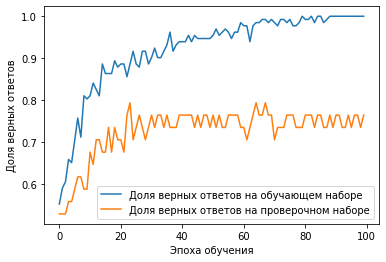

In [ ]:
# Выводим график точности на обучающей выборке
# label - имя графика в легенде
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')

# Выводим график точности на проверочной выборке
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')

# Выводим подписи осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')

# Выводим легенду
plt.legend()
plt.show()

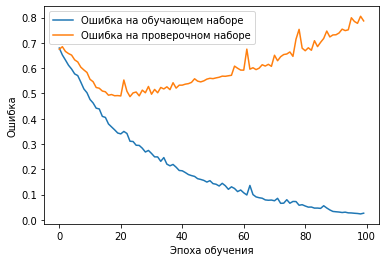

In [ ]:
# Выводим графики ошибки
plt.plot(history.history['loss'], 
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

## Слой Dropout

*Разбор данного раздела:* https://youtu.be/ZNVupJXQisM?t=1879


In [ ]:
# Создаём сеть
model = Sequential()
model.add(Dropout(0.3, input_shape=(60,)))    # 0.3 означает, что 30% нейронов будут 'выключены'
model.add(Dense(60, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Компилируем сеть
# lr=0.001 - размер шага обучения
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

# Обучаем сеть
history = model.fit(x_train, 
                      y_train, 
                      batch_size=8, 
                      epochs=200,
                      validation_split=0.2, 
                      verbose=1)

Epoch 1/200
17/17 [==============================] - 0s 13ms/step - loss: 0.7018 - accuracy: 0.5076 - val_loss: 0.6924 - val_accuracy: 0.5294
Epoch 2/200
17/17 [==============================] - 0s 4ms/step - loss: 0.7071 - accuracy: 0.5227 - val_loss: 0.6904 - val_accuracy: 0.5294
Epoch 3/200
17/17 [==============================] - 0s 5ms/step - loss: 0.6859 - accuracy: 0.5379 - val_loss: 0.6882 - val_accuracy: 0.5294
Epoch 4/200
17/17 [==============================] - 0s 5ms/step - loss: 0.6770 - accuracy: 0.5455 - val_loss: 0.6850 - val_accuracy: 0.5294
Epoch 5/200
17/17 [==============================] - 0s 5ms/step - loss: 0.6752 - accuracy: 0.5606 - val_loss: 0.6878 - val_accuracy: 0.5294
Epoch 6/200
17/17 [==============================] - 0s 5ms/step - loss: 0.6797 - accuracy: 0.5758 - val_loss: 0.6799 - val_accuracy: 0.5294
Epoch 7/200
17/17 [==============================] - 0s 5ms/step - loss: 0.6839 - accuracy: 0.5379 - val_loss: 0.6812 - val_accuracy: 0.5294
Epoch 8/200


In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 60)                3660      
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 30)                1830      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 31        
Total params: 5,521
Trainable params: 5,521
Non-trainable params: 0
____________________________________________________

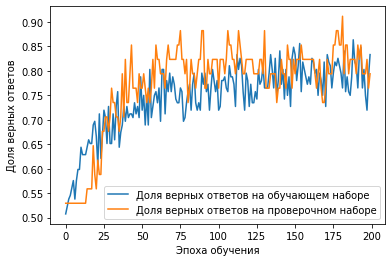

In [ ]:
# Выводим график точности на обучающей выборке
# label - имя графика в легенде
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')

# Выводим график точности на проверочной выборке
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')

# Выводим подписи осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')

# Выводим легенду
plt.legend()
plt.show()

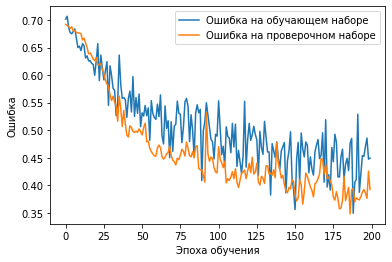

In [ ]:
# Выводим графики ошибки
plt.plot(history.history['loss'], 
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

## Нормализация

*Разбор данного раздела:* https://youtu.be/ZNVupJXQisM?t=2134

Epoch 1/100
1/1 [==============================] - 0s 190ms/step - loss: 0.9037 - accuracy: 0.4545 - val_loss: 0.6965 - val_accuracy: 0.4706
Epoch 2/100
1/1 [==============================] - 0s 24ms/step - loss: 0.8407 - accuracy: 0.4697 - val_loss: 0.6950 - val_accuracy: 0.5000
Epoch 3/100
1/1 [==============================] - 0s 26ms/step - loss: 0.7832 - accuracy: 0.5076 - val_loss: 0.6937 - val_accuracy: 0.5294
Epoch 4/100
1/1 [==============================] - 0s 24ms/step - loss: 0.7316 - accuracy: 0.5227 - val_loss: 0.6926 - val_accuracy: 0.5588
Epoch 5/100
1/1 [==============================] - 0s 23ms/step - loss: 0.6847 - accuracy: 0.5682 - val_loss: 0.6914 - val_accuracy: 0.5588
Epoch 6/100
1/1 [==============================] - 0s 24ms/step - loss: 0.6421 - accuracy: 0.6288 - val_loss: 0.6902 - val_accuracy: 0.5588
Epoch 7/100
1/1 [==============================] - 0s 27ms/step - loss: 0.6036 - accuracy: 0.6894 - val_loss: 0.6892 - val_accuracy: 0.5588
Epoch 8/100
1/1 [==

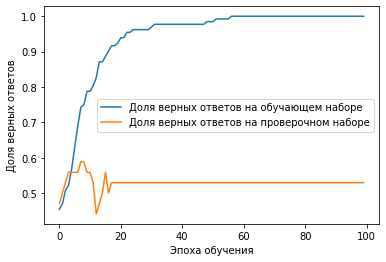

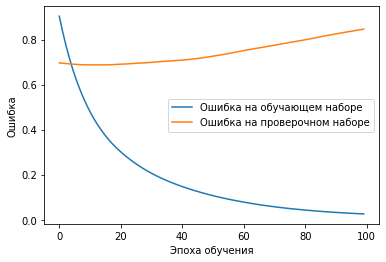

In [ ]:
model = Sequential()

# Добавляем слой пакетной нормализации
# Теперь input_shape=(60, ) надо указывать в нём
# А не в первом полносвязном слое
model.add(BatchNormalization(input_shape=(60, )))
model.add(Dense(60, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(30, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

history = model.fit(x_train, 
                    y_train, 
                    batch_size=200, 
                    epochs=100,
                    validation_split=0.2,
                    verbose=1)

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

#Выводим графики ошибки
plt.plot(history.history['loss'], 
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

Epoch 1/100
1/1 [==============================] - 0s 181ms/step - loss: 1.0839 - accuracy: 0.3939 - val_loss: 0.6784 - val_accuracy: 0.5882
Epoch 2/100
1/1 [==============================] - 0s 27ms/step - loss: 1.0267 - accuracy: 0.4848 - val_loss: 0.6772 - val_accuracy: 0.5588
Epoch 3/100
1/1 [==============================] - 0s 24ms/step - loss: 0.9229 - accuracy: 0.4848 - val_loss: 0.6762 - val_accuracy: 0.6176
Epoch 4/100
1/1 [==============================] - 0s 23ms/step - loss: 1.0738 - accuracy: 0.4242 - val_loss: 0.6753 - val_accuracy: 0.5882
Epoch 5/100
1/1 [==============================] - 0s 25ms/step - loss: 0.8044 - accuracy: 0.5455 - val_loss: 0.6743 - val_accuracy: 0.5588
Epoch 6/100
1/1 [==============================] - 0s 23ms/step - loss: 0.8772 - accuracy: 0.5682 - val_loss: 0.6735 - val_accuracy: 0.5588
Epoch 7/100
1/1 [==============================] - 0s 27ms/step - loss: 0.8145 - accuracy: 0.5530 - val_loss: 0.6729 - val_accuracy: 0.5294
Epoch 8/100
1/1 [==

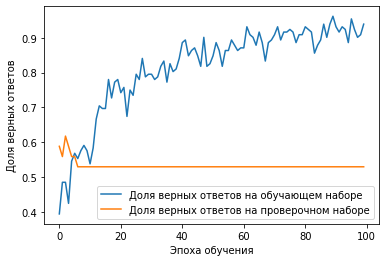

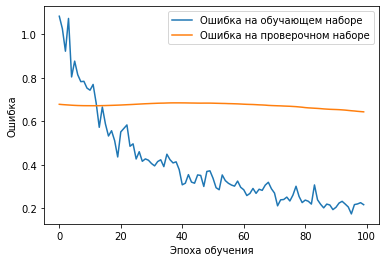

In [ ]:
model = Sequential()

# Добавляем слой пакетной нормализации
# Теперь input_shape=(784, ) надо указывать в нём
# А не в первом полносвязном слое
model.add(Dense(60, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(30, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

history = model.fit(x_train, 
                    y_train, 
                    batch_size=200, 
                    epochs=100,
                    validation_split=0.2,
                    verbose=1)

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

# Выводим графики ошибки
plt.plot(history.history['loss'], 
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

# Предсказание цен машин с Юлы

*Разбор данного раздела:* https://youtu.be/ZNVupJXQisM?t=2386

In [ ]:
# Загружаем файлы
files.upload()
!ls # Выводим содержимое корневой папки

In [ ]:
# Считываем csv с помощью pandas
cars = pd.read_csv('cars_new.csv', sep=',')
cars[:5] # Выводим первые 5 машин 

mark                               model   price  ...    fuel  volume  power
0        kia                              cerato  996000  ...  бензин     2.0  150.0
1     daewoo  nexia 1 поколение [2-й рестайлинг]  140200  ...  бензин     1.5   80.0
2     suzuki      jimny 3 поколение [рестайлинг]  750000  ...  бензин     1.3   85.0
3        bmw              x1 18 e84 [рестайлинг]  970000  ...  бензин     2.0  150.0
4  chevrolet                 lacetti 1 поколение  205000  ...  бензин     1.4   95.0

[5 rows x 10 columns]

In [ ]:
print(cars.values.shape)

In [ ]:
# Создаём словарь поле - его индекс
def create_dict(s):
  ret = {}                          # Создаём пустой словарь
  for _id, name in enumerate(s):    # Проходим по всем парам - id и название
    ret.update({name: _id})         # Добавляем в словарь
  return ret

# Функция преобразования в one hot encoding
def to_ohe(value, d):
  arr = [0] * len(d)
  arr[d[value]] = 1
  return arr

In [ ]:
# Создаём словари по всем текстовым колонкам
marks_dict = create_dict(set(cars['mark']))
models_dict = create_dict(set(cars['model']))
bodies_dict = create_dict(set(cars['body']))
kpps_dict = create_dict(set(cars['kpp']))
fuels_dict = create_dict(set(cars['fuel']))

# Запоминаем цены
prices = np.array(cars['price'], dtype=np.float)

# Запоминаем числовые параметры
# и нормируем
years = preprocessing.scale(cars['year'])
mileages = preprocessing.scale(cars['mileage'])
volumes = preprocessing.scale(cars['volume'])
powers = preprocessing.scale(cars['power'])

In [ ]:
print(marks_dict)

{'bmw': 0, 'mercedes-benz': 1, 'hyundai': 2, 'mitsubishi': 3, 'ford': 4, 'toyota': 5, 'daewoo': 6, 'renault': 7, 'mazda': 8, 'nissan': 9, 'chevrolet': 10, 'suzuki': 11, 'peugeot': 12, 'kia': 13, 'skoda': 14, 'audi': 15, 'subaru': 16, 'volkswagen': 17, 'honda': 18, 'chery': 19, 'opel': 20}


In [ ]:
years.mean()

7.129646144783743e-15

In [ ]:
years.std()

1.0

In [ ]:
print(powers)

[ 0.22905575 -0.95630346 -0.87163494 ...  0.22905575 -0.75309902
  2.34576862]


In [ ]:
# Создаём пустую обучающую выборку
x_train = []
y_train = []

# Проходам по всем машинам
for _id, car in enumerate(np.array(cars)):
  # В y_train добавляем цену
  y_train.append(prices[_id])
  
  # В x_train объединяем все параметры
  # Категорийные параметры добавляем в виде ohe
  # Числовые параметры добавляем напрямую
  x_tr = to_ohe(car[0], marks_dict) + \
        to_ohe(car[1], models_dict) + \
        to_ohe(car[5], bodies_dict) + \
        to_ohe(car[6], kpps_dict) + \
        to_ohe(car[7], fuels_dict) + \
        [years[_id]] + \
        [mileages[_id]] + \
        [volumes[_id]] + \
        [powers[_id]]
  
  # Добавляем текущую строку в общий x_train
  x_train.append(x_tr)

# Превращаем лист в numpy.array
x_train = np.array(x_train, dtype=np.float)
y_train = np.array(y_train, dtype=np.float)

In [ ]:
# Выводим размеры выборок
print(x_train.shape)
print(y_train.shape)

(70119, 3208)
(70119,)


In [ ]:
# Выводим один x_train
print(x_train[0,:20])
print(x_train[0,-20:])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          1.          1.5200145  -1.40018212
  0.12288486  0.22905575]


In [ ]:
# Выводим y_train
print(y_train[:10])

[ 996000.  140200.  750000.  970000.  205000.  985000.  589000.  500000.
 1320000.  270000.]


In [ ]:
# Нормализуем y_train
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1,1)).flatten()

# y_train.reshape(-1,1) добавляет одну размерность
# Это нужно потому, что y_scaler.fit_transform
# Требует двумерны вектор, массив примеров, которые надо нормализовать
# Он не умеет работать с одним примеров
# Поэтому мы делаем массив из одного примера
# На выходе он так же выдаёт массив примеров
# Но нам нужен только первый пример
# Поэтому мы делаем flatten() - уменьшение размерности

In [ ]:
y_train_scaled.shape

(70119,)

In [ ]:
# Выводим базовый и нормированный y_train
print(y_train[:10])
print(y_train_scaled[:10])

[ 996000.  140200.  750000.  970000.  205000.  985000.  589000.  500000.
 1320000.  270000.]
[ 0.75082432 -0.62135434  0.3563911   0.70913625 -0.51745486  0.73318706
  0.09824578 -0.04445567  1.27032173 -0.4132347 ]


In [ ]:
model_ula = Sequential()
model_ula.add(Dense(300, activation = 'relu', input_shape = x_train.shape[1:]))
model_ula.add(Dense(100, activation = 'relu'))
model_ula.add(Dense(1))
model_ula.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])
# training
model_ula.fit(x_train, y_train_scaled, epochs = 20, batch_size = 32, validation_split = 0.1)

predict = model_ula.predict(x_test)


# Глоссарий

**Типы выборок:**

*   *Обучающая выборка* - основной набор данных, на котором происходит обучение нейронной сети
*   *Проверочная выборка* - набор данных, на котором отслеживается качество работы сети в процессе обучения
*   *Тестовая выборка* - контрольный набор данных, на котором проверяется качество работы обученной сети



**Способы формирования проверочной выборки:**


*   validation_split - указываем процент от обучающей выборки, который будет использоваться в качестве проверочной
*   validation_data - указываем готовые наборы данных, которые будут использоваться в качестве проверочной выборки

**Переобучение сети** - ситуация, при которой сеть "заучила" исходную обучающую выборку и не способна производить обобщение данных (верно распознавать данные из проверочных и тестовых наборов)

**Способы преодоления переобучения:**


*   Dropout - принудительное "отключение" случайного числа нейронов
*   BatchNormalization - нормализация данных на выходе слоя

**StandardScaler** - класс нормализации данных (приводит переданный набор числовых данных к нормальному распределению)

